In [2]:
#library
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from scipy.integrate import solve_ivp

In [19]:
#define parameters
n_species = 4
n_cs = 10 # cs = carbon sources

#default values
g = np.ones(n_species) # conversion factor from energy uptake to growth rate, for species i ## all 1's, so all the energy is converted into growth ?
m = np.zeros(n_species) # minimal energy uptake for maintenance of species (energy/time)
l = 0.2*np.ones((n_species, n_cs)) # leakage fractions for resource 'a' (unitless)
K = 1e-3*np.ones(n_cs) # consider making this small  ## WHAT IS THIS
w = np.ones(n_cs) # all metabolites have the same energy
d = 0.1 # dilution rate
c =  np.ones((n_species,n_cs)) #maximum uptake of a ressource a by a species i
J = np.zeros((n_species, n_cs)) #energie intake d'in individu i par une ressource a
D = np.zeros((n_species, n_cs, n_cs)) #matrice du by product d'une ressource b produit par un individu i consommant une ressource a)

In [47]:
N0 = [ # list of initial population densities
    1e-4, # species 1
    1e-3, # species 2
    1e-5, # species 3
    1e-4  # species 4
    ]
R0 = np.zeros(n_cs) # concentration of resources at t=0 (mass/volume)
R0[0] = 10 # first resource has a concentration of 10 (why ?) parce que après on va peut être obtenir les autres ressources grace aux byproduct
y0 = np.append(np.array(N0),R0)

In [41]:
def CR_model(t, y):

  N = y[:n_species]
  R = y[n_species:]

  J = np.zeros((n_species, n_cs))
  for i in range(n_species):
    for a in range(n_cs):
      J[i,a] = c[i,a]*R[a]/(R[a]+K[a])

  dNdt = np.zeros(n_species)
  for i in range(n_species):
    growth_intake = np.sum([(J[i, a]*w[a]*(1-l[i,a]))-m[i]for a in range(n_cs)])
    dNdt[i] = g[i]*N[i]*growth_intake-(N[i]*d)

  dRdt = np.zeros(n_cs)
  for a in range(n_cs):
    consumption = np.sum([N[i]*J[i,a] for i in range(n_species)])
    byproduction_tot = np.zeros((n_species, n_cs))
    for i in range(n_species):
      for b in range(n_cs):
        byproduction_tot[i,b] = D[i,a,b]*w[b]*l[i,b]*N[i]*J[i,b]/w[a]
    byproduction = np.sum(byproduction_tot)
    dRdt[a] = (R0[a]-R[a])*d - consumption + byproduction

  return np.concatenate((dNdt,dRdt))

In [45]:
t_span = (0,300)
t_eval = np.linspace(t_span[0], t_span[1],300)

In [48]:
solutions = solve_ivp(CR_model, t_span, y0, t_eval=t_eval)

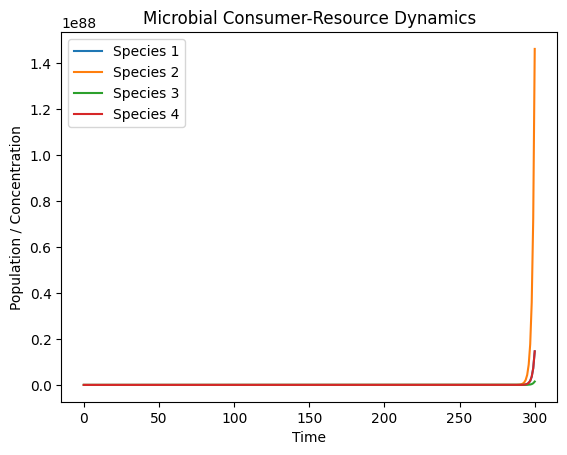

In [49]:
plt.plot(solutions.t, solutions.y[0], label='Species 1')
plt.plot(solutions.t, solutions.y[1], label='Species 2')
plt.plot(solutions.t, solutions.y[2], label='Species 3')
plt.plot(solutions.t, solutions.y[3], label='Species 4')
plt.title('Microbial Consumer-Resource Dynamics')
plt.xlabel('Time')
plt.ylabel('Population / Concentration')
plt.legend()
plt.show()